In [ ]:
# !pip install ultralytics 

In [5]:
import os
import glob
import pandas as pd
import json
import yaml
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from ultralytics import RTDETR
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
# Data path
data_path = '/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope'

# Check 
print("Dataset structure:", os.listdir(data_path))

Dataset structure: ['README.roboflow.txt', 'valid', 'test', 'train']


In [7]:
# check for labels files
json_files = glob.glob(os.path.join(data_path, '**/*.json'), recursive=True)
print(f"Found .json files: {len(json_files)}")

if json_files:
    print("\nSample .json files:")
    for f in json_files[:5]:
        print(f"  {f}")

Found .json files: 3

Sample .json files:
  /kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/valid/_annotations.coco.json
  /kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/test/_annotations.coco.json
  /kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/train/_annotations.coco.json


In [8]:
#check labels
# Load annotations
with open(os.path.join(data_path, 'train/_annotations.coco.json'), 'r') as f:
    annot = json.load(f)

# Show categories
print(annot.keys())
print(annot['categories'][0].keys())
print(annot['images'][0].keys())
print(annot['annotations'][0].keys())

print("\n Annotations:")
ann_df = pd.DataFrame(annot['annotations'])
print(ann_df.head())


dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
dict_keys(['id', 'name'])
dict_keys(['id', 'license', 'file_name', 'height', 'width', 'date_captured'])
dict_keys(['id', 'image_id', 'category_id', 'bbox', 'area', 'segmentation', 'iscrowd'])

 Annotations:
   id  image_id  category_id                    bbox     area  \
0   0         0            1  [505, 518, 47.2, 24.8]  1170.56   
1   1         1            1    [334, 222, 68, 15.2]  1033.60   
2   2         2            1   [566, 66, 73.6, 22.4]  1648.64   
3   3         3            1    [513, 241, 31.5, 92]  2898.00   
4   4         4            1    [0, 254, 63.2, 68.8]  4348.16   

                                        segmentation  iscrowd  
0  [[543.2, 520, 542.4, 520.8, 541.6, 521.6, 540....        0  
1  [[379.2, 223.2, 379.2, 224, 378.4, 224.8, 377....        0  
2  [[572, 68, 572, 68.8, 571.2, 69.6, 571.2, 70.4...        0  
3                                                 []        0  
4  [[0, 277

## convert coco annotations to yolo format

In [7]:
# !pip install pylabel
import random
import shutil
from pylabel import importer, exporter, visualize

In [9]:
import shutil
from collections import defaultdict

dataset_root = data_path
output_root = "/kaggle/working/rt-detr"
splits = ["train", "valid", "test"]

if os.path.exists(output_root):
    shutil.rmtree(output_root)

for split in splits:
    print(f"Processing {split}")

    json_path = os.path.join(dataset_root, split, "_annotations.coco.json")
    images_dir = os.path.join(dataset_root, split)  

    out_img_dir = os.path.join(output_root, "images", split)
    out_lbl_dir = os.path.join(output_root, "labels", split)

    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    with open(json_path) as f:
        coco = json.load(f)

    imgs = {i["id"]: i for i in coco["images"]}
    cats = sorted(coco["categories"], key=lambda x: x["id"])
    cat_map = {c["id"]: i for i, c in enumerate(cats)}

    anns = defaultdict(list)
    for a in coco["annotations"]:
        anns[a["image_id"]].append(a)

    for img_id, img in imgs.items():
        w, h = img["width"], img["height"]
        fname = os.path.basename(img["file_name"])
        name = os.path.splitext(fname)[0]

        # write label
        with open(os.path.join(out_lbl_dir, name + ".txt"), "w") as f:
            for a in anns.get(img_id, []):
                x, y, bw, bh = a["bbox"]
                xc = (x + bw / 2) / w
                yc = (y + bh / 2) / h
                bw /= w
                bh /= h
                f.write(f"{cat_map[a['category_id']]} {xc} {yc} {bw} {bh}\n")

        # copy image
        shutil.copy(
            os.path.join(images_dir, fname),
            os.path.join(out_img_dir, fname)
        )

# dataset.yaml
yaml = [
    f"path: {output_root}",
    "train: images/train",
    "val: images/valid",
    "test: images/test",
    f"nc: {len(cats)}",
    "names:"
]
for i, c in enumerate(cats):
    yaml.append(f"  {i}: {c['name']}")

with open(os.path.join(output_root, "dataset.yaml"), "w") as f:
    f.write("\n".join(yaml))


Processing train
Processing valid
Processing test


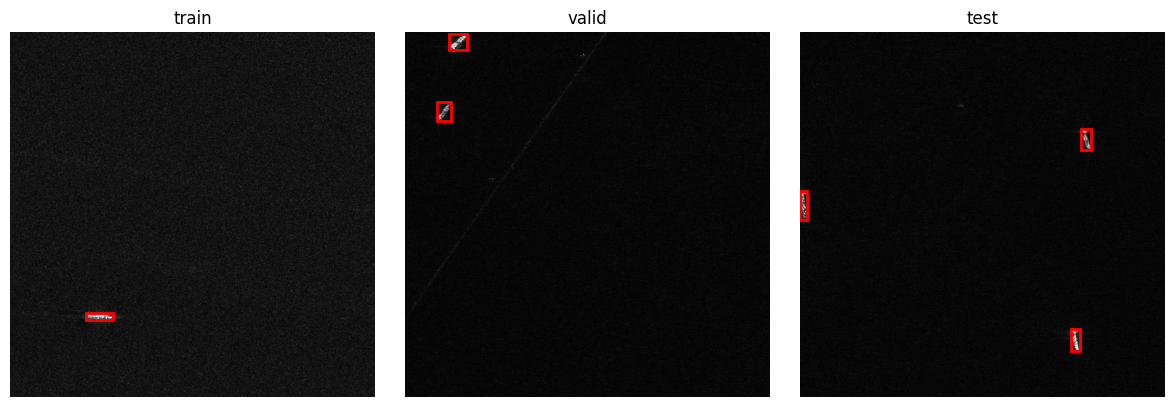

In [10]:
import random

def plot_boxes(ax, img_path, label_path):
    img = Image.open(img_path)
    w, h = img.size
    ax.imshow(img)
    ax.axis("off")

    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f.readlines():
                class_id, xc, yc, bw, bh = map(float, line.strip().split())
                x_center = xc * w
                y_center = yc * h
                box_w = bw * w
                box_h = bh * h
                x_min = x_center - box_w / 2
                y_min = y_center - box_h / 2
                rect = patches.Rectangle(
                    (x_min, y_min), box_w, box_h,
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax.add_patch(rect)
                # ax.text(x_min, y_min-5, f"{int(class_id)}", color='yellow', fontsize=8, weight='bold')

# base directories
img_base = "/kaggle/working/rt-detr/images"
label_base = "/kaggle/working/rt-detr/labels"
# splits = ["train", "valid", "test"]

fig, axes = plt.subplots(1, 3, figsize=(12,4))  # 1 row, 3 images
for ax, split in zip(axes, splits):
    imgs = [f for f in os.listdir(os.path.join(img_base, split)) if f.endswith((".jpg",".png"))]
    img_file = random.choice(imgs)
    img_path = os.path.join(img_base, split, img_file)
    label_path = os.path.join(label_base, split, os.path.splitext(img_file)[0]+".txt")
    plot_boxes(ax, img_path, label_path)
    ax.set_title(split)

plt.tight_layout()
plt.show()


## Model training

In [11]:
# Check GPU
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")


GPU Available: True
GPU Name: Tesla T4


In [29]:
# Clear GPU memory
import gc

# Delete any existing models
if 'model_baseline' in globals():
    del model_baseline
if 'model' in globals():
    del model
if 'best_model' in globals():
    del best_model

# Clear cache
gc.collect()
torch.cuda.empty_cache()

print("GPU memory cleared")
print(f"GPU memory allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
print(f"GPU memory reserved: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")

GPU memory cleared
GPU memory allocated: 0.96 GB
GPU memory reserved: 3.01 GB


In [30]:
# Load pretrained model
model = RTDETR('rtdetr-l.pt')

In [31]:
# train
train_results = model.train(
    data="/kaggle/working/rt-detr/dataset.yaml",  
    epochs=10,
    batch=16,
    imgsz=640
)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/rt-detr/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       1/10      13.3G     0.6024      1.076     0.1246         19        640: 100% ━━━━━━━━━━━━ 295/295 1.3s/it 6:12<1.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 1.3it/s 32.2s0.7ss
                   all       1346       3781      0.837      0.648      0.761       0.46

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       2/10      13.3G     0.5191      0.494    0.08953         28        640: 100% ━━━━━━━━━━━━ 295/295 1.2s/it 5:59<1.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 1.4it/s 29.8s0.7ss
                   all       1346       3781      0.833      0.723      0.806      0.504

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       3/10      14.2G     0.5045      0.481    0.07943         23        640: 100% ━━━━━━━━━━━━ 295/295 1.2s/it 5:57<1.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 1.4it/s 29.7s0.7ss
                   all       1346       3781      0.863      0.739      0.833      0.513

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       4/10      13.9G      0.489     0.4766    0.07728         35        640: 100% ━━━━━━━━━━━━ 295/295 1.2s/it 5:56<1.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 1.5it/s 29.6s0.7ss
                   all       1346       3781      0.887      0.736      0.834      0.518

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       5/10      13.1G     0.4545     0.4534    0.06916         31        640: 100% ━━━━━━━━━━━━ 295/295 1.2s/it 5:56<1.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 1.5it/s 29.6s0.7ss
                   all       1346       3781      0.873       0.78      0.872      0.574

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       6/10      13.9G     0.4478     0.4354    0.06861         36        640: 100% ━━━━━━━━━━━━ 295/295 1.2s/it 5:56<1.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 1.5it/s 29.6s0.7ss
                   all       1346       3781      0.865        0.8      0.877      0.579

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       7/10      13.3G     0.4314     0.4297      0.066         21        640: 100% ━━━━━━━━━━━━ 295/295 1.2s/it 5:56<1.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 1.5it/s 29.6s0.7ss
                   all       1346       3781      0.896      0.798       0.89      0.598

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       8/10        14G     0.4221     0.4262    0.06242         17        640: 100% ━━━━━━━━━━━━ 295/295 1.2s/it 5:56<1.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 1.4it/s 29.7s0.7ss
                   all       1346       3781       0.91      0.834      0.911      0.614

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       9/10      13.3G     0.4018     0.4109    0.05873         18        640: 100% ━━━━━━━━━━━━ 295/295 1.2s/it 5:56<1.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 1.5it/s 29.6s0.7ss
                   all       1346       3781      0.914      0.834      0.911      0.614

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      10/10      13.3G      0.386     0.4076    0.05607         20        640: 100% ━━━━━━━━━━━━ 295/295 1.2s/it 5:56<1.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 1.5it/s 29.6s0.7ss
                   all       1346       3781      0.916      0.838      0.917      0.606

10 epochs completed in 1.083 hours.
Optimizer stripped from /kaggle/working/runs/detect/train5/weights/last.pt, 66.2MB
Optimizer stripped from /kaggle/working/runs/detect/train5/weights/best.pt, 66.2MB

Validating /kaggle/working/runs/detect/train5/weights/best.pt...
Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 310 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 1.5it/s 29.5s0.7ss
                   all       1346       3781      0.911      0.836      0.911      0.614
S